In [7]:
import pandas as pd

# Load the uploaded WHO COVID-19 dataset
file_path = r"WHO-COVID-19-global-daily-data.csv"
df = pd.read_csv(file_path)

# Display basic info and the first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482640 entries, 0 to 482639
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_reported      482640 non-null  object 
 1   Country_code       480629 non-null  object 
 2   Country            482640 non-null  object 
 3   WHO_region         482640 non-null  object 
 4   New_cases          209891 non-null  float64
 5   Cumulative_cases   482640 non-null  int64  
 6   New_deaths         153753 non-null  float64
 7   Cumulative_deaths  482640 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 29.5+ MB


(None,
   Date_reported Country_code     Country WHO_region  New_cases  \
 0    2020-01-04           AI    Anguilla        AMR        NaN   
 1    2020-01-04           AZ  Azerbaijan        EUR        NaN   
 2    2020-01-04           BD  Bangladesh       SEAR        0.0   
 3    2020-01-04           BB    Barbados        AMR        NaN   
 4    2020-01-04           BR      Brazil        AMR        NaN   
 
    Cumulative_cases  New_deaths  Cumulative_deaths  
 0                 0         NaN                  0  
 1                 0         NaN                  0  
 2                 0         0.0                  0  
 3                 0         NaN                  0  
 4                 0         NaN                  0  )

In [8]:
# Step 1: Convert 'Date_reported' to datetime
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# Step 2: Handle missing values

# Drop rows where 'Country_code' is missing (minimal %)
df = df.dropna(subset=['Country_code'])

# Fill missing 'New_cases' and 'New_deaths' with 0 (assumed no cases/deaths reported)
df['New_cases'] = df['New_cases'].fillna(0)
df['New_deaths'] = df['New_deaths'].fillna(0)

# Step 3: Outlier Detection (basic statistics)
new_cases_stats = df['New_cases'].describe()
new_deaths_stats = df['New_deaths'].describe()

# Step 4: Check for negative values (invalid)
negative_cases = df[df['New_cases'] < 0]
negative_deaths = df[df['New_deaths'] < 0]

new_cases_stats, new_deaths_stats, negative_cases.shape[0], negative_deaths.shape[0]


(count    4.806290e+05
 mean     1.619202e+03
 std      3.217967e+04
 min     -6.507900e+04
 25%      0.000000e+00
 50%      0.000000e+00
 75%      2.900000e+01
 max      6.966046e+06
 Name: New_cases, dtype: float64,
 count    480629.000000
 mean         14.760512
 std         138.851684
 min       -3520.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max       44047.000000
 Name: New_deaths, dtype: float64,
 60,
 30)

In [9]:
# Replace negative values in 'New_cases' and 'New_deaths' with 0
df['New_cases'] = df['New_cases'].apply(lambda x: max(x, 0))
df['New_deaths'] = df['New_deaths'].apply(lambda x: max(x, 0))

# Verify no negative values remain
neg_cases_remaining = (df['New_cases'] < 0).sum()
neg_deaths_remaining = (df['New_deaths'] < 0).sum()

neg_cases_remaining, neg_deaths_remaining


(np.int64(0), np.int64(0))

In [10]:
# Save the cleaned dataset to a new CSV file
cleaned_file_path = "cleaned_WHO_COVID19_data.csv"
df.to_csv(cleaned_file_path, index=False)

cleaned_file_path


'cleaned_WHO_COVID19_data.csv'

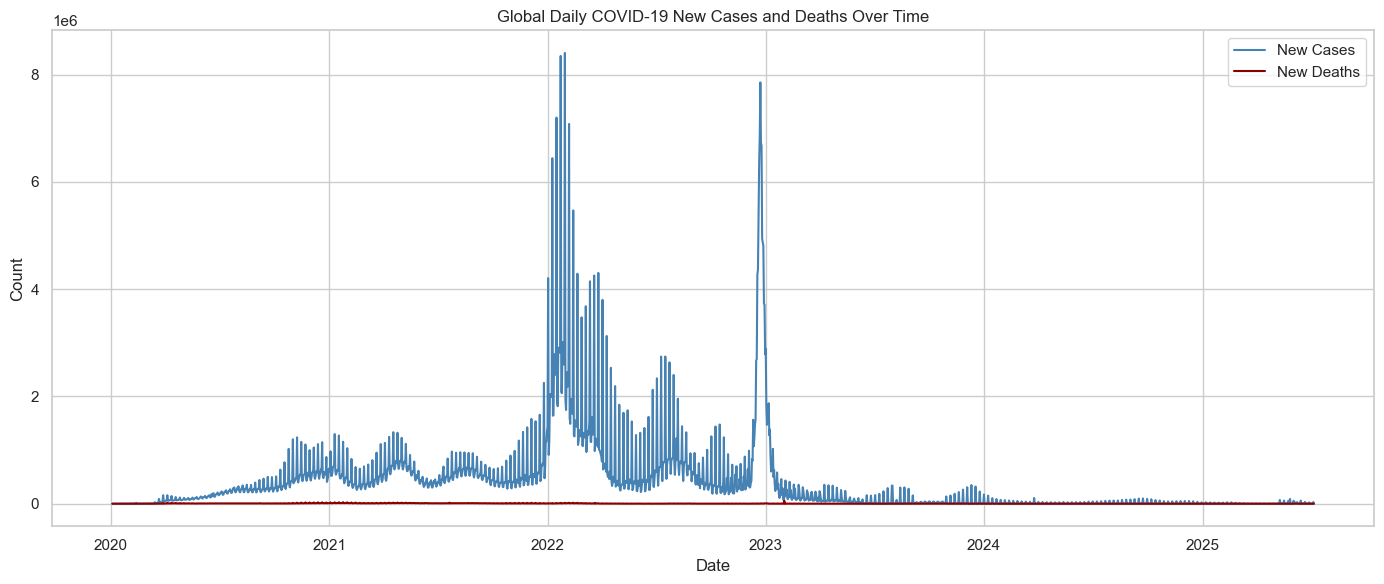

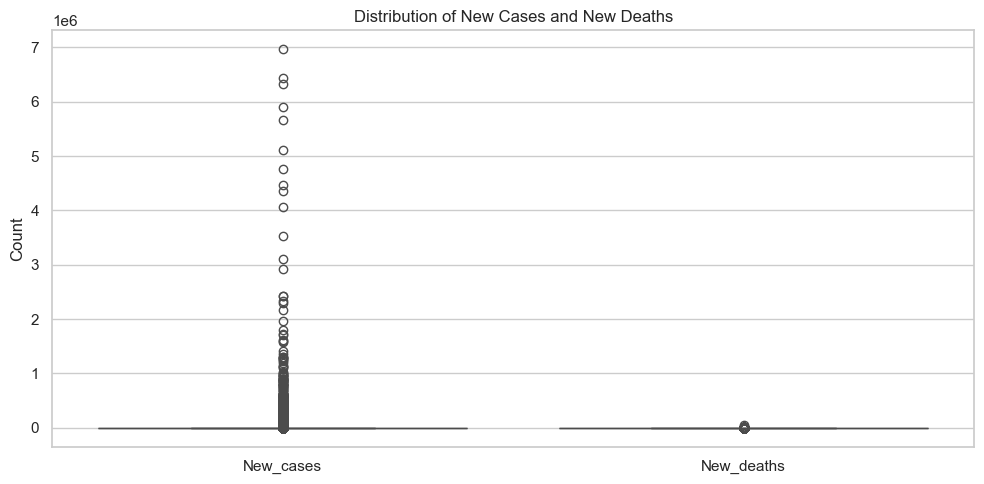

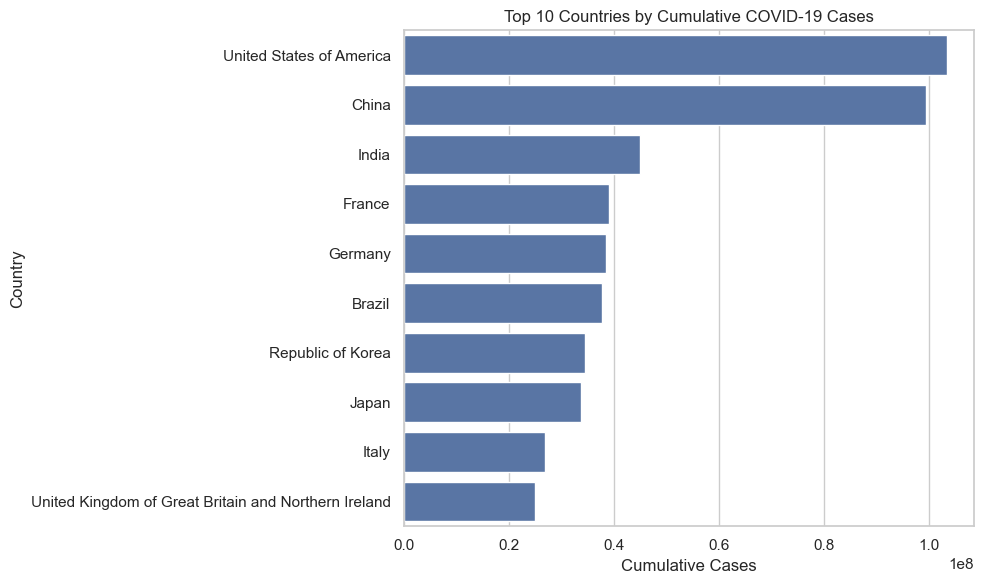

In [14]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your cleaned dataset
df = pd.read_csv("cleaned_WHO_COVID19_data.csv")
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Global Daily Trends
global_daily = df.groupby('Date_reported')[['New_cases', 'New_deaths']].sum()

plt.figure(figsize=(14, 6))
plt.plot(global_daily.index, global_daily['New_cases'], label='New Cases', color='steelblue')
plt.plot(global_daily.index, global_daily['New_deaths'], label='New Deaths', color='darkred')
plt.title('Global Daily COVID-19 New Cases and Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Boxplot of New Cases and New Deaths
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['New_cases', 'New_deaths']])
plt.title('Distribution of New Cases and New Deaths')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3. Top 10 Countries by Cumulative Cases
top_countries = df.groupby('Country')['Cumulative_cases'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Cumulative COVID-19 Cases')
plt.xlabel('Cumulative Cases')
plt.ylabel('Country')
plt.tight_layout()
plt.show()


In [15]:
pip install pandas scikit-learn matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


C:\Users\mushi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.8591


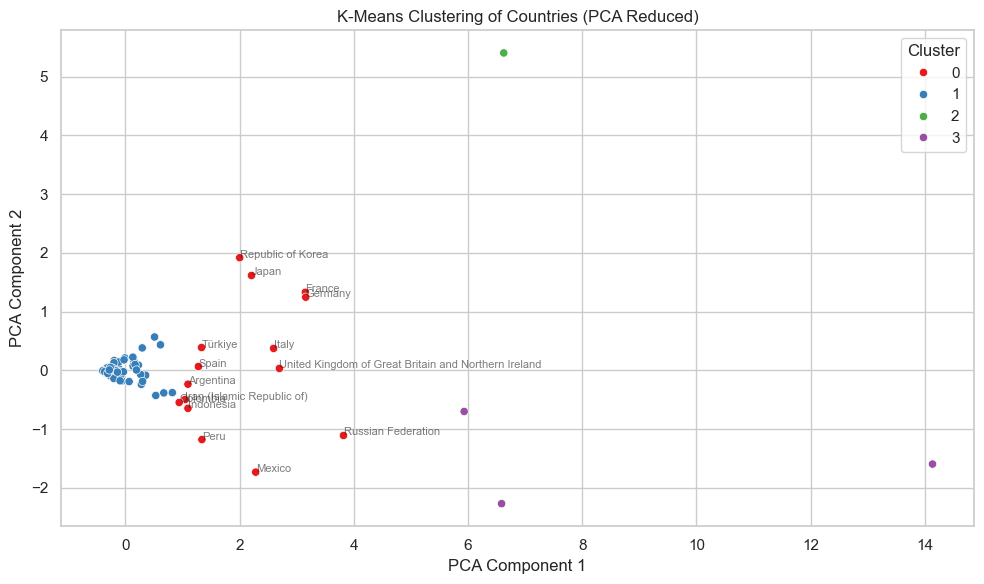

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# -----------------------------
# Step 1: Load and preprocess data
# -----------------------------
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date_reported'] = pd.to_datetime(df['Date_reported'])

    # Aggregate to latest cumulative values per country
    latest_df = df.sort_values('Date_reported').groupby('Country').tail(1)

    # Select features
    features = latest_df[['Cumulative_cases', 'Cumulative_deaths']]
    countries = latest_df['Country']

    # Normalize data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    return scaled_features, countries, features

# -----------------------------
# Step 2: Run K-Means Clustering
# -----------------------------
def run_kmeans_model(data, k=3):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data)
    return kmeans, clusters

# -----------------------------
# Step 3: Evaluate Clustering
# -----------------------------
def evaluate_clusters(data, clusters):
    score = silhouette_score(data, clusters)
    print(f"Silhouette Score: {score:.4f}")
    return score

# -----------------------------
# Step 4: Visualize Clusters with PCA
# -----------------------------
def visualize_clusters(data, clusters, countries):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette='Set1')
    for i, country in enumerate(countries):
        if clusters[i] == 0:  # Optional: label one cluster
            plt.text(reduced[i, 0], reduced[i, 1], country, fontsize=8, alpha=0.6)
    plt.title("K-Means Clustering of Countries (PCA Reduced)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Main Pipeline
# -----------------------------
if __name__ == "__main__":
    file_path = "cleaned_WHO_COVID19_data.csv"  # Update path if needed

    # Preprocessing
    scaled_data, countries, raw_features = preprocess_data(file_path)

    # Clustering
    model, cluster_labels = run_kmeans_model(scaled_data, k=4)

    # Evaluation
    evaluate_clusters(scaled_data, cluster_labels)

    # Visualization
    visualize_clusters(scaled_data, cluster_labels, countries)
